In [1]:
if "CHANGED_DIR" not in globals():
    CHANGED_DIR = True
    %cd ..

/export/compvis-nfs/user/jomuelle/publish/nitro


In [2]:
import datetime
from pathlib import Path

import numpy as np
import torch
import torchvision
from clip import tokenize
from einops import rearrange
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from tqdm.auto import tqdm, trange

from ipywidgets import interact

from ldm.util import instantiate_from_config

# Load Model

Assume that all models are in the given format in `models/rarm/**` with a `config.yaml` and `model.ckpt` file. You will need to adjust this for self-trained models

In [3]:
# choose which model we want to load

paths = [p.parent for p in Path("models/rarm/").glob("**/model.ckpt")]
paths.sort()
@interact(model_path=paths)
def choose_model(model_path: str):
    global model_dir, config_path, ckpt_path
    model_dir = model_path
    config_path = model_dir / "config.yaml"
    ckpt_path = model_dir / "model.ckpt"
    assert config_path.is_file(), f"Did not found config at {config_path}"

interactive(children=(Dropdown(description='model_path', options=(PosixPath('models/rarm/imagenet/animals'), P…

In [4]:
# actually loading the model

# Setting load patches from neighbors (requires open images/database to be downloaded)
load_patch_dataset = True

# Load model configuration and change some settings
config = OmegaConf.load(config_path)
config.model.params.retrieval_cfg.params.load_patch_dataset = load_patch_dataset
# Don't load anything on any gpu until told to do so
# alternatively call with `CUDA_VISIBLE_DEVICES=...`
config.model.params.retrieval_cfg.params.gpu = False
config.model.params.retrieval_cfg.params.retriever_config.params.device = "cpu"

# Load state dict
pl_sd = torch.load(ckpt_path, map_location="cpu")
global_step = pl_sd["global_step"]

# Initialize model
model = instantiate_from_config(config.model)

# Apply checkpoint
m, u = model.load_state_dict(pl_sd["state_dict"])
if len(m) > 0:
    print(f"Missing keys: \n {m}")
if len(u) > 0:
    print(f"Unexpected keys: \n {u}")
print("Loaded model.")

# Eval mode
model = model.eval()

faiss not available. Go on and hope for the best
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 16385 as a sos token.
Loaded nn_memory of size 165536
No module named 'torch_geometric'
### need to install torch-sparse.
Building Full OpenImages Dataset. Get a Coffee.


Remove Corrupts: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 253/253 [00:17<00:00, 14.68it/s]


Max number of patches per image is 3
Min number of patches per image is 2
N samples in PatcherDataset is 20000000
Batch size: 100; patch_div: 3; dset_batch_size: 33
Load saved patch embedding from "/export/compvis-nfs/group/datasets/retrieval_datasets/2022-03-10T11-39-35-FullOpenImagesTrain-ClipImageRetriever-256/"
Setting timestamp to "2022-03-10T11-39-35"
Start prefetching...


Loading datapool from 1 individual files.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:11<00:00, 191.72s/it]


Prefetching complete. [301.5583736896515 sec.]
Finished loading of retrieval database of length 20000000.
No predefined savedir for searcher, setting to /export/compvis-nfs/group/datasets/retrieval_datasets/searchers/FullOpenImagesTrain_0020M_256
Loaded model.


# Image Utility Functions

In [5]:
def rescale(x: torch.Tensor) -> torch.Tensor:
    return (x + 1.)/2.

def bchw_to_np(x, grid=False, clamp=False):
    if grid:
        x = torchvision.utils.make_grid(x, nrow=min(x.shape[0], 4))[None, ...]
    x = rescale(rearrange(x.detach().cpu(), "b c h w -> b h w c"))
    if clamp:
        x.clamp_(0, 1)
    return x.numpy()

def custom_to_pil(x):
    if isinstance(x,np.ndarray):
        x = torch.from_numpy(x)
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

# Sampling Settings

In [6]:
if torch.cuda.is_available():
    options = ["cpu"] + [f"cuda:{x}" for x in range(torch.cuda.device_count())]
    @interact(device_id=options)
    def device_selector(device_id):
        global device, model
        device = torch.device(device_id)
        model = model.to(device)
        # retriever is no nn.Module, so device changes are not passed through
        model.retriever.retriever.to(device)
else:
    device = torch.device("cpu")

interactive(children=(Dropdown(description='device_id', options=('cpu', 'cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'…

In [7]:
# How many images to generate at once
batch_size = 4
# repeat sampling this number of times
n_runs = 2
# set to number to seed samples
seed = None
# whether to increase the guidance parameter by one for each run
increase_guidance = False
# Keep same queries for each run
keep_qids = False

if seed is not None and (not increase_guidance) and r_runs > 1:
    print("Warning: You will get the same images each run")

# sampling temperature
temperature    = 1.0
# classifier free (transformer) guidance
guidance_scale = 1.0
# top-k sampling (see config.model.first_stage.config.params.n_embed for number of token classes)
top_k          = 256
# top_m sampling as described in the paper (either in (0, 1.] or {1, ..., len(database)}
top_m          = 0.01
# number of neighbors drawn for sampling
k_nn           = 4

if top_m > 1.0:
    # top_m should be int if a fixed number of images is given
    top_m = int(top_m)

# whether to use a caption
use_caption   = False
# caption used for sampling
caption       = "A small corgi"
# use the caption only, no neighbors
only_caption  = False
# Sample "unconditonal" as in the unconditional part of cfg
unconditional = False
# Use proposal distribution weights (else sample uniform under top_m)
use_weights   = False

# Sampling

  0%|          | 0/2 [00:00<?, ?it/s]

Sampling query and neighbors (wait for the sampling to start)


  0%|          | 0/256 [00:00<?, ?it/s]

training searcher...
load pretrained searcher from /export/compvis-nfs/group/datasets/retrieval_datasets/searchers/FullOpenImagesTrain_0020M_256
Finished loading searcher.
done training searcher
Top-M Sampling with memory size 1655
Full sampling takes about 7.46 seconds.
Run 1/2


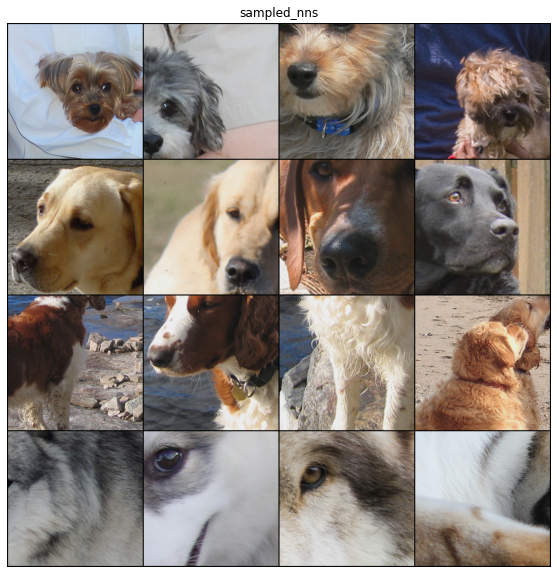

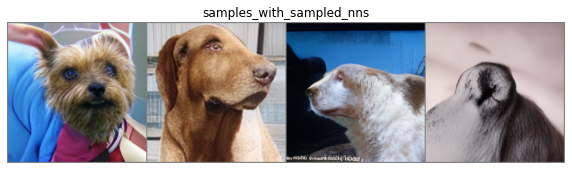

Sampling query and neighbors (wait for the sampling to start)


  0%|          | 0/256 [00:00<?, ?it/s]

Top-M Sampling with memory size 1655
Run 2/2


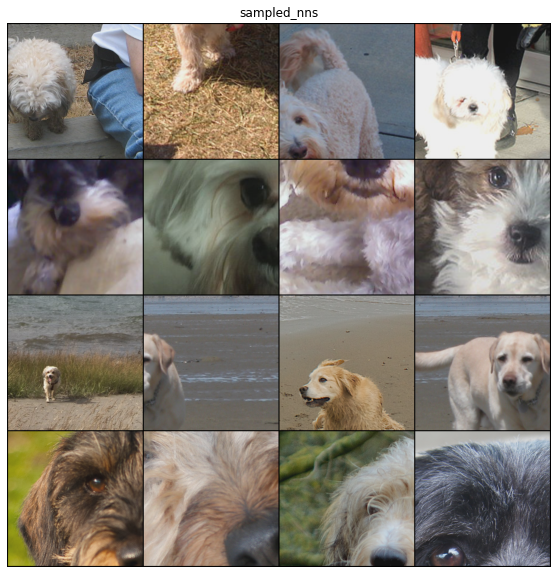

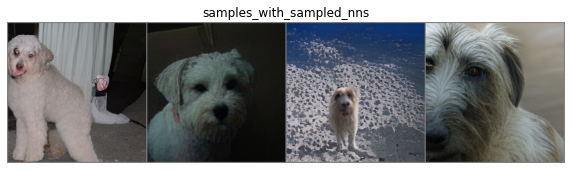

Done


In [8]:
with torch.no_grad():
    qids = None

    sampling_start = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    query_embeddings = None
    nn_embeddings = None
    if use_caption or only_caption:
        tokenized = tokenize([caption]*batch_size).to(model.device)
        clip = model.retriever.retriever.model
        query_embeddings = clip.encode_text(tokenized).cpu()
        del tokenized
    if only_caption:
        nn_embeddings = query_embeddings.unsqueeze(1).to(model.device).float()
    elif unconditional:
        nn_embeddings = torch.zeros((batch_size, 1, 512), dtype=torch.float, device=model.device)

    for n in trange(n_runs):
        if seed is not None:
            seed_everything(seed)

        tqdm.write("Sampling query and neighbors (wait for the sampling to start)")
        S = 256 # number of steps (assumes first stage has f16)
        pbar = tqdm(total=S)
        progress_cb = lambda k: pbar.update()

        # Here is where the magic happens:
        logs = model.sample_from_rdata(
                batch_size,
                qids=qids,
                query_embeddings=query_embeddings,
                nn_embeddings=nn_embeddings,
                k_nn=k_nn,
                return_nns=load_patch_dataset,
                use_weights=use_weights,
                memsize=top_m,
                top_k=top_k,
                guidance_scale=guidance_scale,
                callback=progress_cb
        )
        if keep_qids:
            assert "qids" in logs
            qids = logs["qids"]
        plotting_keys = []
        for key in logs:
            if (key == "samples_with_sampled_nns"
                    or (key == "sampled_nns" and (n==0 or not keep_qids))
                    ):
                plotting_keys.append(key)
        plotting_keys.sort()
        
        tqdm.write(f"Run {n+1}/{n_runs}")
        for idx, key in enumerate(plotting_keys):
            try:
                fig = plt.figure(figsize=(10, 10))
                plt.imshow(bchw_to_np(logs[key], grid=True, clamp=True)[0])
                plt.axis("off")
                plt.title(key)
                plt.show()
            except Exception as e:
                tqdm.write(f"logging {key} not possible due to the following:")
                tqdm.write(str(e))

        if increase_guidance:
            guidance_scale += 1.0
            tqdm.write(f"New guidance scale: {guidance_scale}")

    print("Done")